<a href="https://colab.research.google.com/github/AVBalajee/Noise-Reduction-RNN/blob/main/Noise_Reduction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D,Conv1DTranspose,Concatenate,Input
import numpy as np
import IPython.display
import glob
from tqdm.notebook import tqdm
import librosa.display
import matplotlib.pyplot as plt

In [1]:
!mkdir "CleanData"
!mkdir "NoisyData"

In [55]:
!unzip  '/content/drive/MyDrive/Colab Notebooks/DS_10283_1942.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/DS_10283_1942.zip
replace clean_trainset_wav.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: clean_trainset_wav.zip  y

replace noisy_trainset_wav.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: noisy_trainset_wav.zip  y

replace noisy_testset_wav.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: noisy_testset_wav.zip   
replace clean_testset_wav.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: clean_testset_wav.zip   
  inflating: trainset_txt.zip        
  inflating: testset_txt.zip         
  inflating: license_text            


In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [56]:
%matplotlib inline

In [57]:
!mkdir "NoisyTest"
!unzip "/content/noisy_testset_wav.zip" -d "NoisyTest"

Archive:  /content/noisy_testset_wav.zip
   creating: NoisyTest/noisy_testset_wav/
  inflating: NoisyTest/noisy_testset_wav/p232_001.wav  
  inflating: NoisyTest/noisy_testset_wav/p232_002.wav  
  inflating: NoisyTest/noisy_testset_wav/p232_003.wav  
  inflating: NoisyTest/noisy_testset_wav/p232_005.wav  
  inflating: NoisyTest/noisy_testset_wav/p232_006.wav  
  inflating: NoisyTest/noisy_testset_wav/p232_007.wav  
  inflating: NoisyTest/noisy_testset_wav/p232_009.wav  
  inflating: NoisyTest/noisy_testset_wav/p232_010.wav  
  inflating: NoisyTest/noisy_testset_wav/p232_011.wav  
  inflating: NoisyTest/noisy_testset_wav/p232_012.wav  
  inflating: NoisyTest/noisy_testset_wav/p232_013.wav  
  inflating: NoisyTest/noisy_testset_wav/p232_014.wav  
  inflating: NoisyTest/noisy_testset_wav/p232_015.wav  
  inflating: NoisyTest/noisy_testset_wav/p232_016.wav  
  inflating: NoisyTest/noisy_testset_wav/p232_017.wav  
  inflating: NoisyTest/noisy_testset_wav/p232_019.wav  
  inflating: NoisyTes

In [58]:
!mkdir "CleanTest"
!unzip "/content/clean_testset_wav.zip" -d "CleanTest"

Archive:  /content/clean_testset_wav.zip
   creating: CleanTest/clean_testset_wav/
  inflating: CleanTest/clean_testset_wav/p232_001.wav  
  inflating: CleanTest/clean_testset_wav/p232_002.wav  
  inflating: CleanTest/clean_testset_wav/p232_003.wav  
  inflating: CleanTest/clean_testset_wav/p232_005.wav  
  inflating: CleanTest/clean_testset_wav/p232_006.wav  
  inflating: CleanTest/clean_testset_wav/p232_007.wav  
  inflating: CleanTest/clean_testset_wav/p232_009.wav  
  inflating: CleanTest/clean_testset_wav/p232_010.wav  
  inflating: CleanTest/clean_testset_wav/p232_011.wav  
  inflating: CleanTest/clean_testset_wav/p232_012.wav  
  inflating: CleanTest/clean_testset_wav/p232_013.wav  
  inflating: CleanTest/clean_testset_wav/p232_014.wav  
  inflating: CleanTest/clean_testset_wav/p232_015.wav  
  inflating: CleanTest/clean_testset_wav/p232_016.wav  
  inflating: CleanTest/clean_testset_wav/p232_017.wav  
  inflating: CleanTest/clean_testset_wav/p232_019.wav  
  inflating: CleanTes

In [8]:

!unzip "/content/clean_trainset_wav.zip" -d "CleanData"
!unzip "/content/noisy_trainset_wav.zip" -d "NoisyData"


Streaming output truncated to the last 5000 lines.
  inflating: NoisyData/p267_421.wav  
  inflating: NoisyData/p268_001.wav  
  inflating: NoisyData/p268_002.wav  
  inflating: NoisyData/p268_003.wav  
  inflating: NoisyData/p268_004.wav  
  inflating: NoisyData/p268_005.wav  
  inflating: NoisyData/p268_006.wav  
  inflating: NoisyData/p268_007.wav  
  inflating: NoisyData/p268_009.wav  
  inflating: NoisyData/p268_010.wav  
  inflating: NoisyData/p268_011.wav  
  inflating: NoisyData/p268_012.wav  
  inflating: NoisyData/p268_013.wav  
  inflating: NoisyData/p268_014.wav  
  inflating: NoisyData/p268_015.wav  
  inflating: NoisyData/p268_016.wav  
  inflating: NoisyData/p268_017.wav  
  inflating: NoisyData/p268_018.wav  
  inflating: NoisyData/p268_019.wav  
  inflating: NoisyData/p268_020.wav  
  inflating: NoisyData/p268_021.wav  
  inflating: NoisyData/p268_022.wav  
  inflating: NoisyData/p268_024.wav  
  inflating: NoisyData/p268_025.wav  
  inflating: NoisyData/p268_026.wav  

## Load the Data

In [10]:
clean_sounds = glob.glob('/content/CleanData/*')
noisy_sounds = glob.glob('/content/NoisyData/*')

clean_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(clean_sounds[0]),desired_channels=1)
for i in tqdm(clean_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  clean_sounds_list = tf.concat((clean_sounds_list,so),0)

noisy_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(noisy_sounds[0]),desired_channels=1)
for i in tqdm(noisy_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  noisy_sounds_list = tf.concat((noisy_sounds_list,so),0)

clean_sounds_list.shape,noisy_sounds_list.shape

  0%|          | 0/11571 [00:00<?, ?it/s]

  0%|          | 0/11571 [00:00<?, ?it/s]

(TensorShape([540938091, 1]), TensorShape([540938091, 1]))

In [11]:
batching_size = 12000

clean_train,noisy_train = [],[]

for i in tqdm(range(0,clean_sounds_list.shape[0]-batching_size,batching_size)):
  clean_train.append(clean_sounds_list[i:i+batching_size])
  noisy_train.append(noisy_sounds_list[i:i+batching_size])

clean_train = tf.stack(clean_train)
noisy_train = tf.stack(noisy_train)

clean_train.shape,noisy_train.shape

  0%|          | 0/45078 [00:00<?, ?it/s]

(TensorShape([45078, 12000, 1]), TensorShape([45078, 12000, 1]))

# Create a tf.data.Dataset

In [14]:
def get_dataset(x_train,y_train):
  dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
  dataset = dataset.shuffle(100).batch(64,drop_remainder=True)
  return dataset

In [13]:
train_dataset = get_dataset(noisy_train[:40000],clean_train[:40000])
test_dataset = get_dataset(noisy_train[40000:],clean_train[40000:])

## Reviewing Sample Waveform

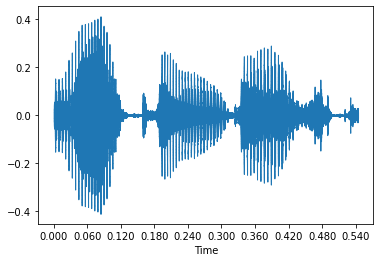

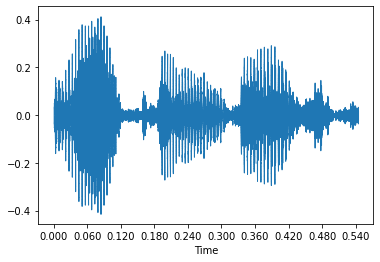

In [15]:
librosa.display.waveshow(np.squeeze(clean_train[5].numpy(),axis=-1))
plt.show()
librosa.display.waveshow(np.squeeze(noisy_train[5].numpy(),axis=-1))
plt.show()

## Creating the Model

In [16]:
inp = Input(shape=(batching_size,1))
c1 = Conv1D(2,32,2,'same',activation='relu')(inp)
c2 = Conv1D(4,32,2,'same',activation='relu')(c1)
c3 = Conv1D(8,32,2,'same',activation='relu')(c2)
c4 = Conv1D(16,32,2,'same',activation='relu')(c3)
c5 = Conv1D(32,32,2,'same',activation='relu')(c4)

dc1 = Conv1DTranspose(32,32,1,padding='same')(c5)
conc = Concatenate()([c5,dc1])
dc2 = Conv1DTranspose(16,32,2,padding='same')(conc)
conc = Concatenate()([c4,dc2])
dc3 = Conv1DTranspose(8,32,2,padding='same')(conc)
conc = Concatenate()([c3,dc3])
dc4 = Conv1DTranspose(4,32,2,padding='same')(conc)
conc = Concatenate()([c2,dc4])
dc5 = Conv1DTranspose(2,32,2,padding='same')(conc)
conc = Concatenate()([c1,dc5])
dc6 = Conv1DTranspose(1,32,2,padding='same')(conc)
conc = Concatenate()([inp,dc6])
dc7 = Conv1DTranspose(1,32,1,padding='same',activation='linear')(conc)
model = tf.keras.models.Model(inp,dc7)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12000, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 6000, 2)      66          ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 3000, 4)      260         ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 1500, 8)      1032        ['conv1d_1[0][0]']               
                                                                                              

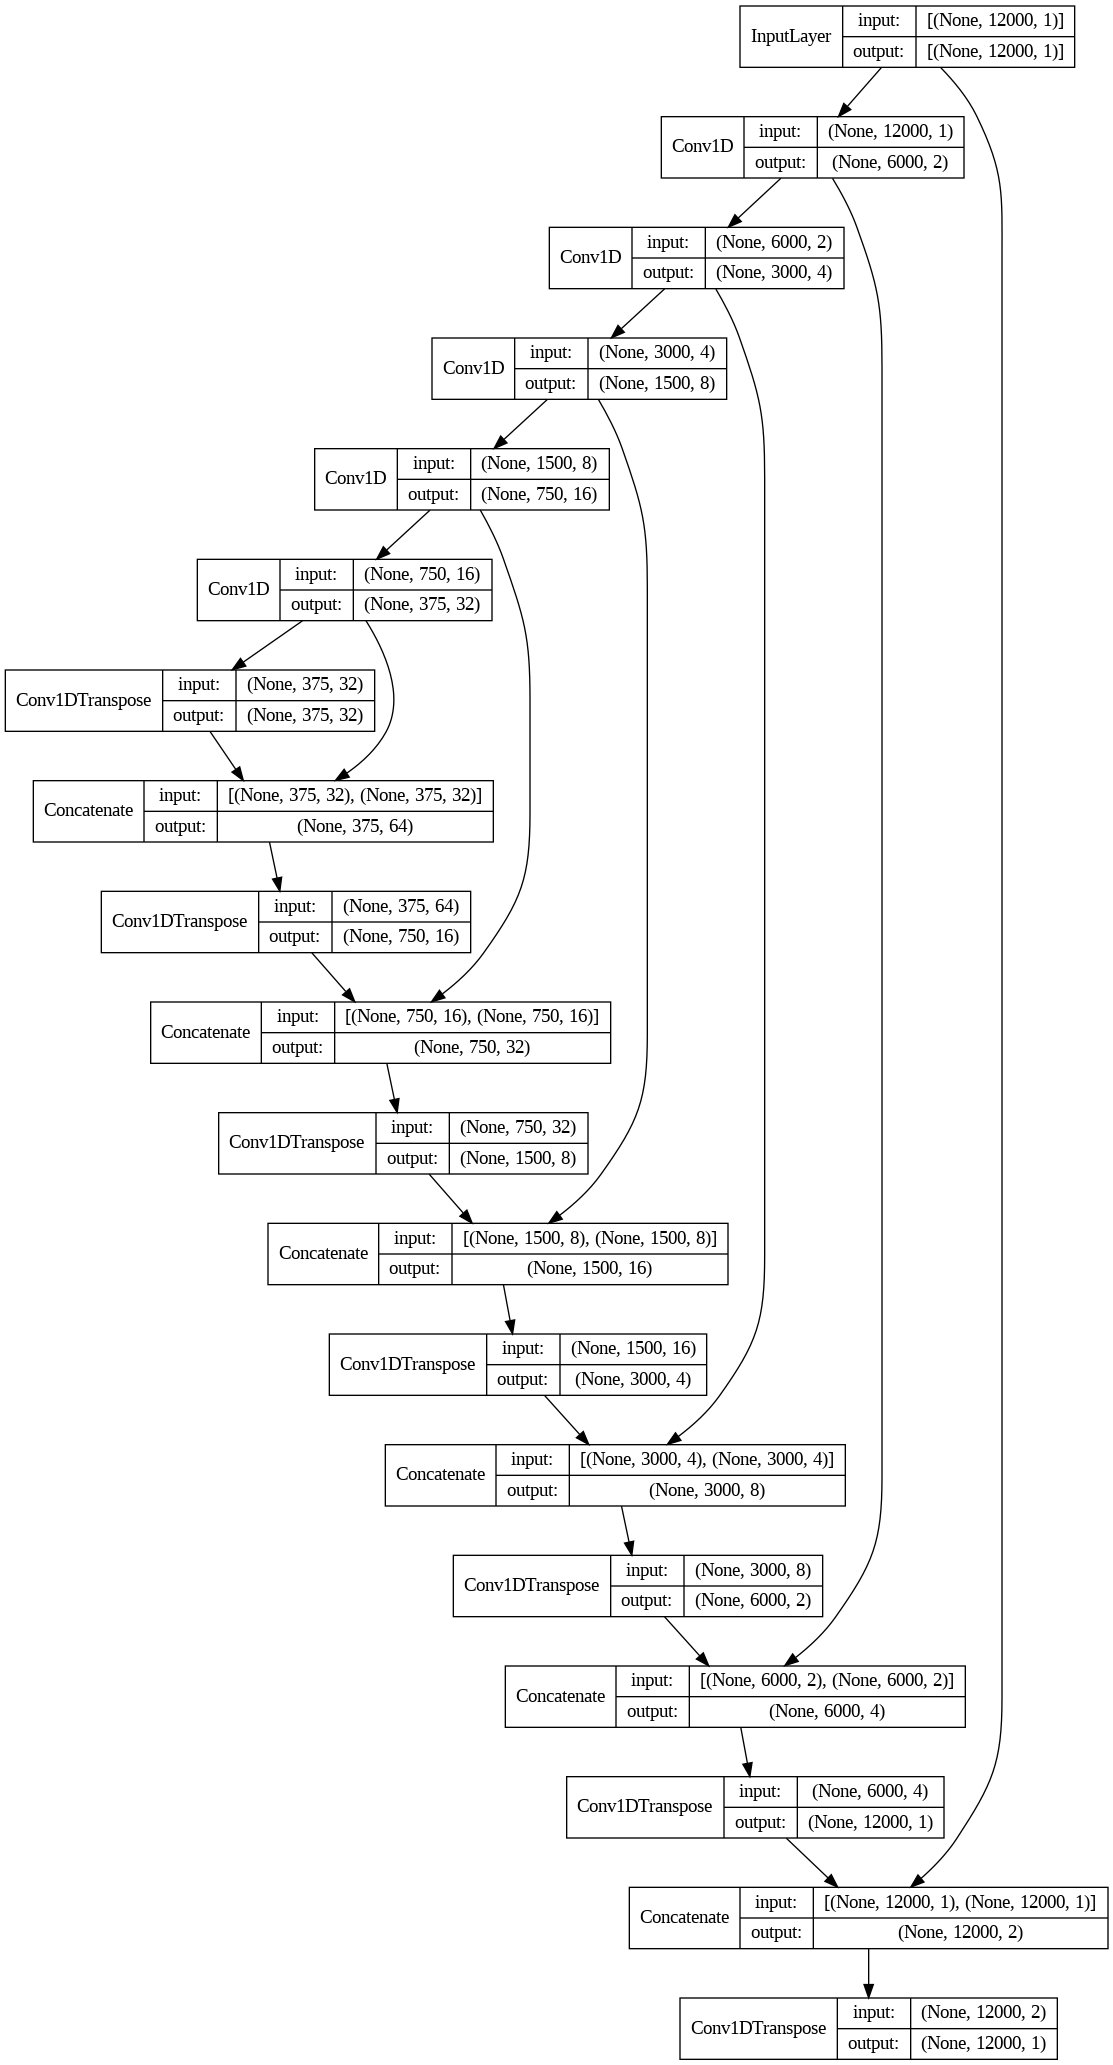

In [17]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=False)

## Training

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.002),loss=tf.keras.losses.MeanAbsoluteError())
history = model.fit(train_dataset,epochs=20)

Epoch 1/20
625/625 [==============================] - 26s 36ms/step - loss: 0.0128
Epoch 2/20
625/625 [==============================] - 19s 31ms/step - loss: 0.0127
Epoch 3/20
625/625 [==============================] - 20s 32ms/step - loss: 0.0127
Epoch 4/20
625/625 [==============================] - 20s 31ms/step - loss: 0.0126
Epoch 5/20
625/625 [==============================] - 19s 31ms/step - loss: 0.0126
Epoch 6/20
625/625 [==============================] - 19s 31ms/step - loss: 0.0126
Epoch 7/20
625/625 [==============================] - 19s 31ms/step - loss: 0.0125
Epoch 8/20
625/625 [==============================] - 19s 31ms/step - loss: 0.0125
Epoch 9/20
625/625 [==============================] - 19s 31ms/step - loss: 0.0125
Epoch 10/20
625/625 [==============================] - 19s 31ms/step - loss: 0.0124
Epoch 11/20
625/625 [==============================] - 19s 31ms/step - loss: 0.0124
Epoch 12/20
625/625 [==============================] - 19s 31ms/step - loss: 0.0124
E

## Testing Samples

In [35]:
from IPython.display import Audio
Audio(np.squeeze(noisy_train[6].numpy()),rate=16000)

In [36]:
Audio(tf.squeeze(model.predict(tf.expand_dims(tf.expand_dims(noisy_train[6],-1),0))),rate=16000)

1/1 [==============================] - 0s 22ms/step


In [37]:
model.evaluate(test_dataset)   

79/79 [==============================] - 2s 15ms/step - loss: 0.0119


0.01190248504281044

In [38]:
model.save('NoiseSuppressionModel.h5')

# Inference

Handling different sized audio inputs can be solved by overlapping prediction frames and removing the intersection part from the final waveform

In [39]:
def get_audio(path):
  audio,_ = tf.audio.decode_wav(tf.io.read_file(path),1)
  return audio

In [40]:
def inference_preprocess(path):
  audio = get_audio(path)
  audio_len = audio.shape[0]
  batches = []
  for i in range(0,audio_len-batching_size,batching_size):
    batches.append(audio[i:i+batching_size])

  batches.append(audio[-batching_size:])
  diff = audio_len - (i + batching_size)
  return tf.stack(batches), diff

In [41]:
def predict(path):
  test_data,diff = inference_preprocess(path)
  predictions = model.predict(test_data)
  final_op = tf.reshape(predictions[:-1],((predictions.shape[0]-1)*predictions.shape[1],1))
  final_op = tf.concat((final_op,predictions[-1][-diff:]),axis=0)
  return final_op

In [42]:
Audio(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1),rate=16000)

In [43]:
Audio(tf.squeeze(predict(noisy_sounds[4])),rate=16000)

1/1 [==============================] - 0s 397ms/step


In [44]:
%%timeit
tf.squeeze(predict(noisy_sounds[3]))

1/1 [==============================] - 0s 21ms/step
58.8 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


1/1 [==============================] - 0s 22ms/step


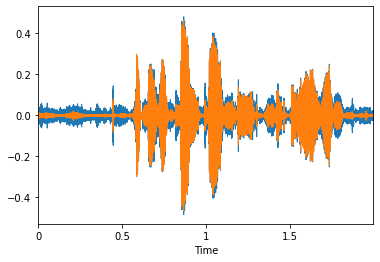

In [45]:
librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1))
librosa.display.waveplot(np.squeeze(predict(noisy_sounds[4])))